In [1]:
import tensorflow as tf
import os
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [2]:
data_dir = 'chest_xray/train'

In [3]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 11858 files belonging to 2 classes.
Metal device set to: Apple M2 Max


2023-09-13 10:14:10.968957: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-13 10:14:10.969093: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
data_iterator = data.as_numpy_iterator()

In [5]:
batch = data_iterator.next()

2023-09-13 10:14:11.037088: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


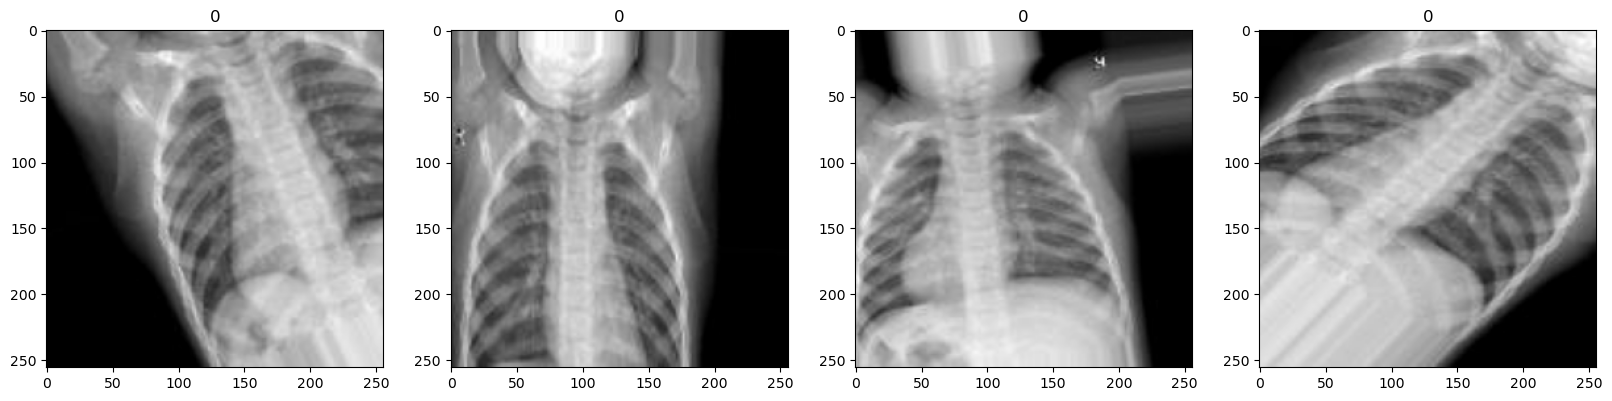

In [6]:
# 0 normal
#1 pneumonia
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img, in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [7]:
data = data.map(lambda x,y: (x/255, y))

In [8]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [9]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [10]:
model = Sequential()

In [11]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer='l2'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy', Recall()])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [14]:
logdir= 'chest_xray/logs'

In [15]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [16]:
hist = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/25


2023-09-13 10:14:11.895004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


258/259 [============================>.] - ETA: 0s - loss: 0.3257 - accuracy: 0.9162 - recall: 0.8252

2023-09-13 10:14:19.413732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


259/259 [==============================] - 14s 51ms/step - loss: 0.3250 - accuracy: 0.9165 - recall: 0.8256 - val_loss: 0.1997 - val_accuracy: 0.9561 - val_recall: 0.9821
Epoch 2/25
259/259 [==============================] - 14s 52ms/step - loss: 0.1389 - accuracy: 0.9731 - recall: 0.9527 - val_loss: 0.1073 - val_accuracy: 0.9793 - val_recall: 0.9791
Epoch 3/25
259/259 [==============================] - 14s 52ms/step - loss: 0.1063 - accuracy: 0.9774 - recall: 0.9632 - val_loss: 0.0910 - val_accuracy: 0.9793 - val_recall: 0.9461
Epoch 4/25
259/259 [==============================] - 14s 52ms/step - loss: 0.0848 - accuracy: 0.9819 - recall: 0.9720 - val_loss: 0.0682 - val_accuracy: 0.9844 - val_recall: 0.9834
Epoch 5/25
259/259 [==============================] - 13s 51ms/step - loss: 0.0674 - accuracy: 0.9846 - recall: 0.9772 - val_loss: 0.0760 - val_accuracy: 0.9848 - val_recall: 0.9611
Epoch 6/25
259/259 [==============================] - 14s 52ms/step - loss: 0.0504 - accuracy: 0.9884

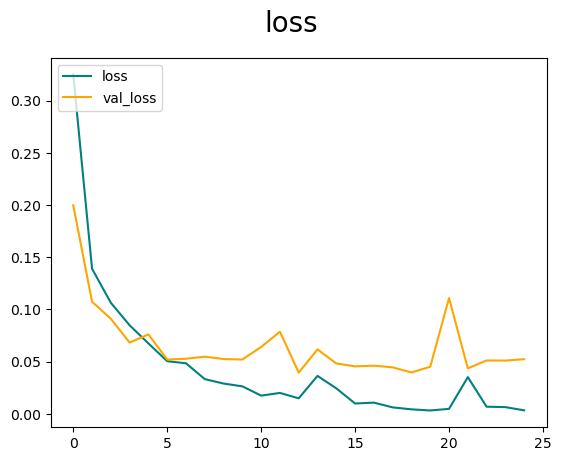

In [17]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

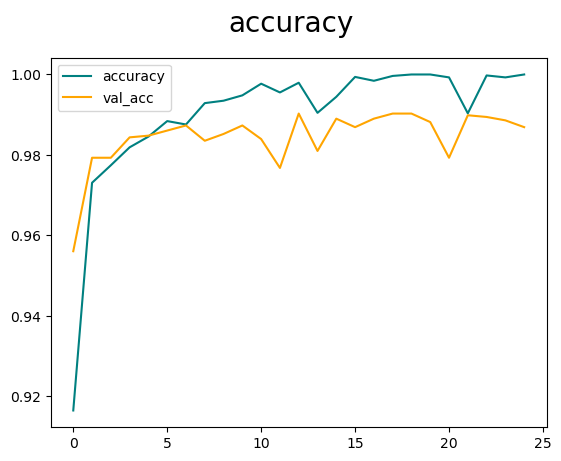

In [18]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

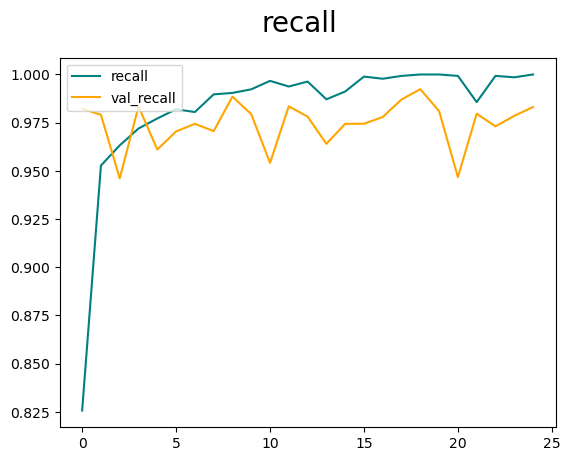

In [19]:
fig = plt.figure()
plt.plot(hist.history['recall'], color='teal', label='recall')
plt.plot(hist.history['val_recall'], color='orange', label='val_recall')
fig.suptitle('recall', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [20]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [21]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 17ms/step


2023-09-13 10:19:57.442666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step
Precision:0.9740932583808899, Recall:0.9817232489585876, Accuracy:0.9856418967247009
